In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

!pip install hydroeval
import hydroeval as he


In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)
  
def create_dataset_X(X, time_steps=1):
    Xs = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

def mean_absolute_percentage_error(y_t, y_p): 
    
    return np.mean(np.abs((y_t - y_p) / y_t)) * 100

In [ ]:
direct = "/content/drive/MyDrive/Final_barley"
crop = "Barley"

lof = os.listdir(direct)

performance_r2 = []
performance_mape = []
performance_nse = []
car_df = []

for f in lof:
  df = pd.read_csv(direct + "/" + f)

  car_df.append(f[7:-4])
  timeline = []
  for i in range(0, len(df["Year"])):
    timeline.append(i)

  df["Weeks"] = timeline

  df.pop("Year")
  df.pop("Area")

  train_size = int(len(df) * 0.9)
  test_size = len(df) - train_size
  train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

  full_data = df

  f_columns = ['SumPcpn', 'SumEGDD_C', 'SumHeatD','SumFrostD','AvgSI', 
             'AvgPrcnAWHC','NDVI']

  f_transformer = StandardScaler()
  yld_transformer = StandardScaler()

  f_transformer = f_transformer.fit(train[f_columns].to_numpy())
  yld_transformer = yld_transformer.fit(train[['Yield']])

  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
  train['Yield'] = yld_transformer.transform(train[['Yield']])

  test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
  test['Yield'] = yld_transformer.transform(test[['Yield']])

  time_steps = 19

  # reshape to [samples, time_steps, n_features]

  X_train, y_train = create_dataset(train, train.Yield, time_steps)
  X_test, y_test = create_dataset(test, test.Yield, time_steps)

  print(X_train.shape, y_train.shape)

  !mkdir -p saved_model
  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128,
        input_shape=(X_train.shape[1], X_train.shape[2])
      )
    )
  )
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  history = model.fit(
      X_train, y_train,
      epochs=30,
      batch_size=32,
      validation_split=0.1,
      shuffle=False,
      verbose = False
  )

  model.save("saved_model" + "/" + f[:-4] + "/" + "model")

  MAX_EPOCHS = 50

  # When training, change Barley_1100 to specific crop

  def compile_and_fit(model, patience=5):
    # Checkpoint callback usage
    checkpoint_path = "saved_model" + "/" + f[:-4] + "/" + "training_1/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    monitor='val_accuracy',
                                                    verbose=1)
    
    #/# Currently using cp_callback instead of early_stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    # Changed from meansquarederror() to SparseCategoricalCrossentropy()
    # optimizer changed from tf.optimizer.Adam() to 'adam'
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer='adam',
                  metrics=[tf.metrics.MeanSquaredError()])

    history = model.fit(X_train, y_train, epochs=MAX_EPOCHS,
                        batch_size=32, validation_split=0.1,
                        callbacks=[cp_callback])
    return history

  for i in range(20):
    
    new_model = tf.keras.models.load_model("saved_model" + "/" + f[:-4] + "/" + "model")
    history = compile_and_fit(new_model)

    new_model.save("saved_model" + "/" + f[:-4] + "/" + "model")

  full_data.loc[:, f_columns] = f_transformer.transform(full_data[f_columns].to_numpy())
  #full_data['Yield'] = yld_transformer.transform(full_data[['Yield']])
  X_full_data = create_dataset_X(full_data, time_steps)

  df_pred = new_model.predict(X_full_data)
  #tf.keras.backend.clear_session()
  df_pred_inv = yld_transformer.inverse_transform(df_pred)

  yld_predict = []

  for i in (df_pred_inv):
    yld_predict.append(i[0])

  df = pd.read_csv(direct + "/" + f)
  yld_data = df["Yield"][19:]

  correlation_matrix = np.corrcoef(yld_data.to_numpy(), yld_predict)
  correlation_xy = correlation_matrix[0,1]
  r2 = correlation_xy**2

  #r2 = r2_score(yld_data, yld_predict)
  mape = mean_absolute_percentage_error(yld_data, yld_predict)
  nse = he.evaluator(he.nse, yld_predict, yld_data)

  performance_r2.append(r2)
  performance_mape.append(mape)
  performance_nse.append(nse[0])

  df = df[19:]
  df["Predict"] = yld_predict

  df.to_csv("/content/drive/MyDrive/" + crop + "_predict/" + f, index=False)

performance_df = pd.DataFrame(data={"CARUID": car_df, "R_squared": performance_r2,
                   "MAPE": performance_mape, "MEI": performance_nse}, index=[0])

performance_df.to_csv("/content/drive/MyDrive/" + crop + "_predict/" + crop + "_performance.csv", index=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

(562, 19, 9) (562,)


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 4s 83ms/step - loss: 0.4196 - mean_squared_error: 0.4196 - val_loss: 0.3969 - val_mean_squared_error: 0.3969

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.3229 - mean_squared_error: 0.3229 - val_loss: 0.2458 - val_mean_squared_error: 0.2458

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 35ms/step - loss: 0.2428 - mean_squared_error: 0.2428 - val_loss: 0.1929 - val_mean_squared_error: 0.1929

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.2481 - mean_squared_error: 0.2481 - val_loss: 0.2756 - val_mean_squared_error: 0.2756

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 35ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 5s 84ms/step - loss: 0.1447 - mean_squared_error: 0.1447 - val_loss: 0.2011 - val_mean_squared_error: 0.2011

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0923 - mean_squared_error: 0.0923 - val_loss: 0.0918 - val_mean_squared_error: 0.0918

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0738 - mean_squared_error: 0.0738 - val_loss: 0.0967 - val_mean_squared_error: 0.0967

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0795 - mean_squared_error: 0.0795 - val_loss: 0.1004 - val_mean_squared_error: 0.1004

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 4s 84ms/step - loss: 0.0877 - mean_squared_error: 0.0877 - val_loss: 0.0649 - val_mean_squared_error: 0.0649

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0675 - mean_squared_error: 0.0675 - val_loss: 0.0925 - val_mean_squared_error: 0.0925

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0914 - val_mean_squared_error: 0.0914

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 0.1573 - val_mean_squared_error: 0.1573

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 35ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 5s 84ms/step - loss: 0.0888 - mean_squared_error: 0.0888 - val_loss: 0.1190 - val_mean_squared_error: 0.1190

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0515 - mean_squared_error: 0.0515 - val_loss: 0.1498 - val_mean_squared_error: 0.1498

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0586 - val_mean_squared_error: 0.0586

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0380 - mean_squared_error: 0.0380 - val_loss: 0.0543 - val_mean_squared_error: 0.0543

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 37ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 4s 85ms/step - loss: 0.0657 - mean_squared_error: 0.0657 - val_loss: 0.0861 - val_mean_squared_error: 0.0861

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.1098 - val_mean_squared_error: 0.1098

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0643 - val_mean_squared_error: 0.0643

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.1181 - val_mean_squared_error: 0.1181

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 4s 84ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.2273 - val_mean_squared_error: 0.2273

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0356 - mean_squared_error: 0.0356 - val_loss: 0.1203 - val_mean_squared_error: 0.1203

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0833 - val_mean_squared_error: 0.0833

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.1422 - val_mean_squared_error: 0.1422

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 4s 84ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0483 - val_mean_squared_error: 0.0483

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.1075 - val_mean_squared_error: 0.1075

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0434 - val_mean_squared_error: 0.0434

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.0734 - val_mean_squared_error: 0.0734

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 35ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 5s 87ms/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0703 - val_mean_squared_error: 0.0703

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0338 - mean_squared_error: 0.0338 - val_loss: 0.1395 - val_mean_squared_error: 0.1395

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0486 - val_mean_squared_error: 0.0486

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0727 - val_mean_squared_error: 0.0727

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 37ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 4s 87ms/step - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0733 - val_mean_squared_error: 0.0733

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - val_loss: 0.0625 - val_mean_squared_error: 0.0625

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0388 - val_mean_squared_error: 0.0388

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0511 - val_mean_squared_error: 0.0511

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 4s 87ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.0529 - val_mean_squared_error: 0.0529

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - val_loss: 0.0405 - val_mean_squared_error: 0.0405

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0491 - val_mean_squared_error: 0.0491

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0877 - val_mean_squared_error: 0.0877

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 37ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 5s 87ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.0314 - val_mean_squared_error: 0.0314

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.1708 - val_mean_squared_error: 0.1708

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0374 - val_mean_squared_error: 0.0374

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0599 - val_mean_squared_error: 0.0599

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 37ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 4s 86ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0383 - val_mean_squared_error: 0.0383

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0908 - val_mean_squared_error: 0.0908

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.0653 - val_mean_squared_error: 0.0653

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0751 - val_mean_squared_error: 0.0751

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 37ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 4s 86ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.1221 - val_mean_squared_error: 0.1221

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0287 - val_mean_squared_error: 0.0287

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.1088 - val_mean_squared_error: 0.1088

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0403 - val_mean_squared_error: 0.0403

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 5s 118ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.1953 - val_mean_squared_error: 0.1953

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0274 - val_mean_squared_error: 0.0274

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.1112 - val_mean_squared_error: 0.1112

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0504 - val_mean_squared_error: 0.0504

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 4s 87ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0480 - val_mean_squared_error: 0.0480

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0671 - val_mean_squared_error: 0.0671

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0776 - val_mean_squared_error: 0.0776

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0288 - val_mean_squared_error: 0.0288

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 37ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 4s 88ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0703 - val_mean_squared_error: 0.0703

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0369 - val_mean_squared_error: 0.0369

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.1113 - val_mean_squared_error: 0.1113

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0598 - val_mean_squared_error: 0.0598

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 4s 89ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0695 - val_mean_squared_error: 0.0695

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0632 - val_mean_squared_error: 0.0632

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0410 - val_mean_squared_error: 0.0410

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.1045 - val_mean_squared_error: 0.1045

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 39ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 5s 90ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0903 - val_mean_squared_error: 0.0903

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0445 - val_mean_squared_error: 0.0445

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0602 - val_mean_squared_error: 0.0602

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0295 - val_mean_squared_error: 0.0295

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 37ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 4s 89ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0779 - val_mean_squared_error: 0.0779

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0604 - val_mean_squared_error: 0.0604

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0750 - val_mean_squared_error: 0.0750

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 53ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0414 - val_mean_squared_error: 0.0414

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 47ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


Epoch 1/50
16/16 [==============================] - 5s 90ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0528 - val_mean_squared_error: 0.0528

Epoch 00001: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0446 - val_mean_squared_error: 0.0446

Epoch 00002: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0668 - val_mean_squared_error: 0.0668

Epoch 00003: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0656 - val_mean_squared_error: 0.0656

Epoch 00004: saving model to saved_model/BARLEY_1100/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 43ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_1100/model/assets


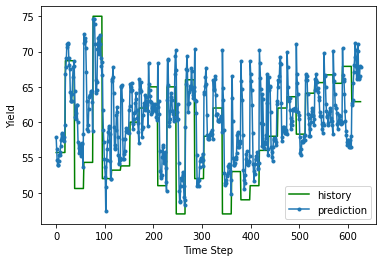

In [ ]:
pred = np.asarray(yld_predict, dtype=np.float32)

plt.plot(np.arange(0, len(yld_data.to_numpy())), yld_data.to_numpy().flatten(), 'g', label="history")
plt.plot(np.arange(0, len(pred)), pred.flatten(), marker='.', label="prediction")
plt.ylabel('Yield')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
correlation_matrix = np.corrcoef(yld_data.to_numpy(), yld_predict)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
he.evaluator(he.nse, yld_predict, yld_data.to_numpy())
r_squared